# Projeto 1

## Tarefa 1

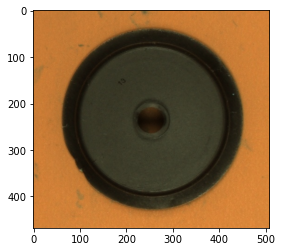

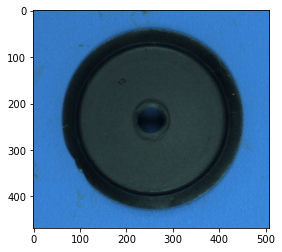

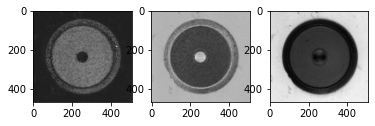

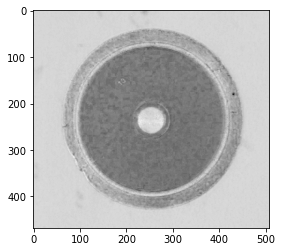

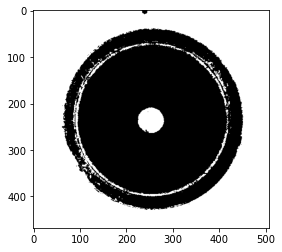

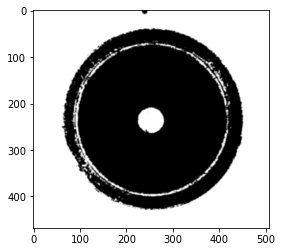

Number of objects detected: 88

Area: 2.0

Area: 6.0

Area: 11.5

Area: 4.0

Area: 2.0

Area: 4.0

Area: 5.5

Area: 2.0

Area: 2.0

Area: 4.0

Area: 2.0

Area: 39.0

Area: 4.0

Area: 2.0

Area: 2.0

Area: 2.0

Area: 4.0

Area: 14.0

Area: 17.5

Area: 26.0

Area: 8.5

Area: 10.5

Area: 4.0

Area: 7.5

Area: 139.0

Area: 2.0

Area: 4.0

Area: 20.5

Area: 2.0

Area: 4.0

Area: 4.0

Area: 2.0

Area: 13.5

Area: 4.0

Area: 4.0

Area: 12.0

Area: 4.0

Area: 2526.5

Area: 4.0

Area: 6.0

Area: 4.0

Area: 6.0

Area: 6.0

Area: 4.0

Area: 4.0

Area: 4.0

Area: 4.0

Area: 4.0

Area: 6.0

Area: 4.0

Area: 2.0

Area: 8.0

Area: 2.0

Area: 11.0

Area: 2.0

Area: 2.0

Area: 2.0

Area: 4.0

Area: 6.0

Area: 7.5

Area: 4.0

Area: 4.0

Area: 5.5

Area: 2.0

Area: 2.0

Area: 4.0

Area: 4.0

Area: 2.0

Area: 36.5

Area: 2.0

Area: 4.0

Area: 8.5

Area: 2.0

Area: 2.0

Area: 2.0

Area: 5.5

Area: 7.0

Area: 7.0

Area: 4.0

Area: 2.0

Area: 35.0

Area: 4.0

Area: 2.0

Area: 4.0

Area: 4.0

Area: 4.0

Area:

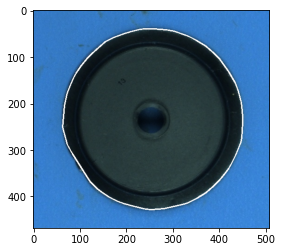

In [39]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt


#fig = cv2.imread("OK/Fig_OK_15.jpg")
#fig = cv2.imread("NOK_superficie/Fig_NOK_Superf_03.jpg")
fig = cv2.imread("NOK_borda/Fig_NOK_15.jpg")

plt.imshow(fig)
plt.show()


figRGB = cv2.cvtColor(fig,cv2.COLOR_BGR2RGB)
plt.imshow(figRGB)
plt.show()


img_hsv = cv2.cvtColor(figRGB, cv2.COLOR_BGR2HSV)
(canal_H, canal_S, canal_V) = cv2.split(img_hsv)
plt.figure("Hue")
plt.subplot(1,3,1)
plt.imshow(canal_H,cmap='gray')
plt.subplot(1,3,2)
plt.imshow(canal_S,cmap='gray')
plt.subplot(1,3,3)
plt.imshow(canal_V,cmap='gray')
plt.show()



#Separando as matrizes
[B,G,R] = cv2.split(figRGB)
#plt.imshow(G, cmap='gray')
#plt.show()

#Binarizando a imagem para fazer o cálculo
#fig_bin = np.where((B>120), 255, 0).astype(np.uint8)
#plt.imshow(fig_bin, cmap='gray')
#plt.show()

gamma = adjust_gamma(canal_S, 5)
plt.imshow(gamma,cmap='gray')
plt.show()


ret,thresh = cv2.threshold(gamma,230,255,0)
plt.imshow(thresh,cmap='gray')
plt.show()


dst = cv2.GaussianBlur(thresh,(3,3),cv2.BORDER_DEFAULT)
plt.imshow(dst,cmap='gray')
plt.show()

#circles = cv2.HoughCircles(fig, cv2.HOUGH_GRADIENT,1,1)
#print(circles)

contours,hierarchy = cv2.findContours(dst, 1, 2)
print("Number of objects detected:", len(contours))

#contours[-5] possui o contorno do circulo na figura 1

for c in contours:
    hull = cv2.convexHull(c)
    #img = cv2.drawContours(fig,[hull],0,(255,255,0),2)
    area = cv2.contourArea(c)
    print("\nArea:",area)
    if (area>10000 and area<200000):
        img = cv2.drawContours(figRGB,[hull],0,(255,255,255),2)
        equi_diameter = np.sqrt(4*area/np.pi)
        print("Diameter:", equi_diameter)
        (x,y),radius = cv2.minEnclosingCircle(c)
        center = (int(x),int(y))
        radius = int(radius)
        #cv2.circle(img,center,radius,(255,255,0),1)
        print("Radius:",radius)
        #cv2.circle(img,center,3,(255,255,0),1)
        plt.imshow(img)
    
plt.show()


#Green para borda
#HUE e SAT para a superfície


#Canal v - rugosidade
#Canal s - borda

In [ ]:
import glob
import cv2
import matplotlib.pyplot as plt


path="OK\*.jpg"    #Replace with your folder 
#path("OK\*.jpg") 
k=glob.glob(path)
images=[cv2.imread(images) for images in glob.glob(path)]

print(len(images))     #number of images in folder
for i in range(len(images)):
    plt.imshow(images[i])
    plt.show()
    #cv2.imshow("images",images[i])
    #cv2.waitKey(0)

In [6]:
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)